In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from missingno import matrix
import joblib

# A. Data Loading
*This markdown includes the following:*
- Importing Data
- Identifying missing data
- Cleaning categorical and numerical columns

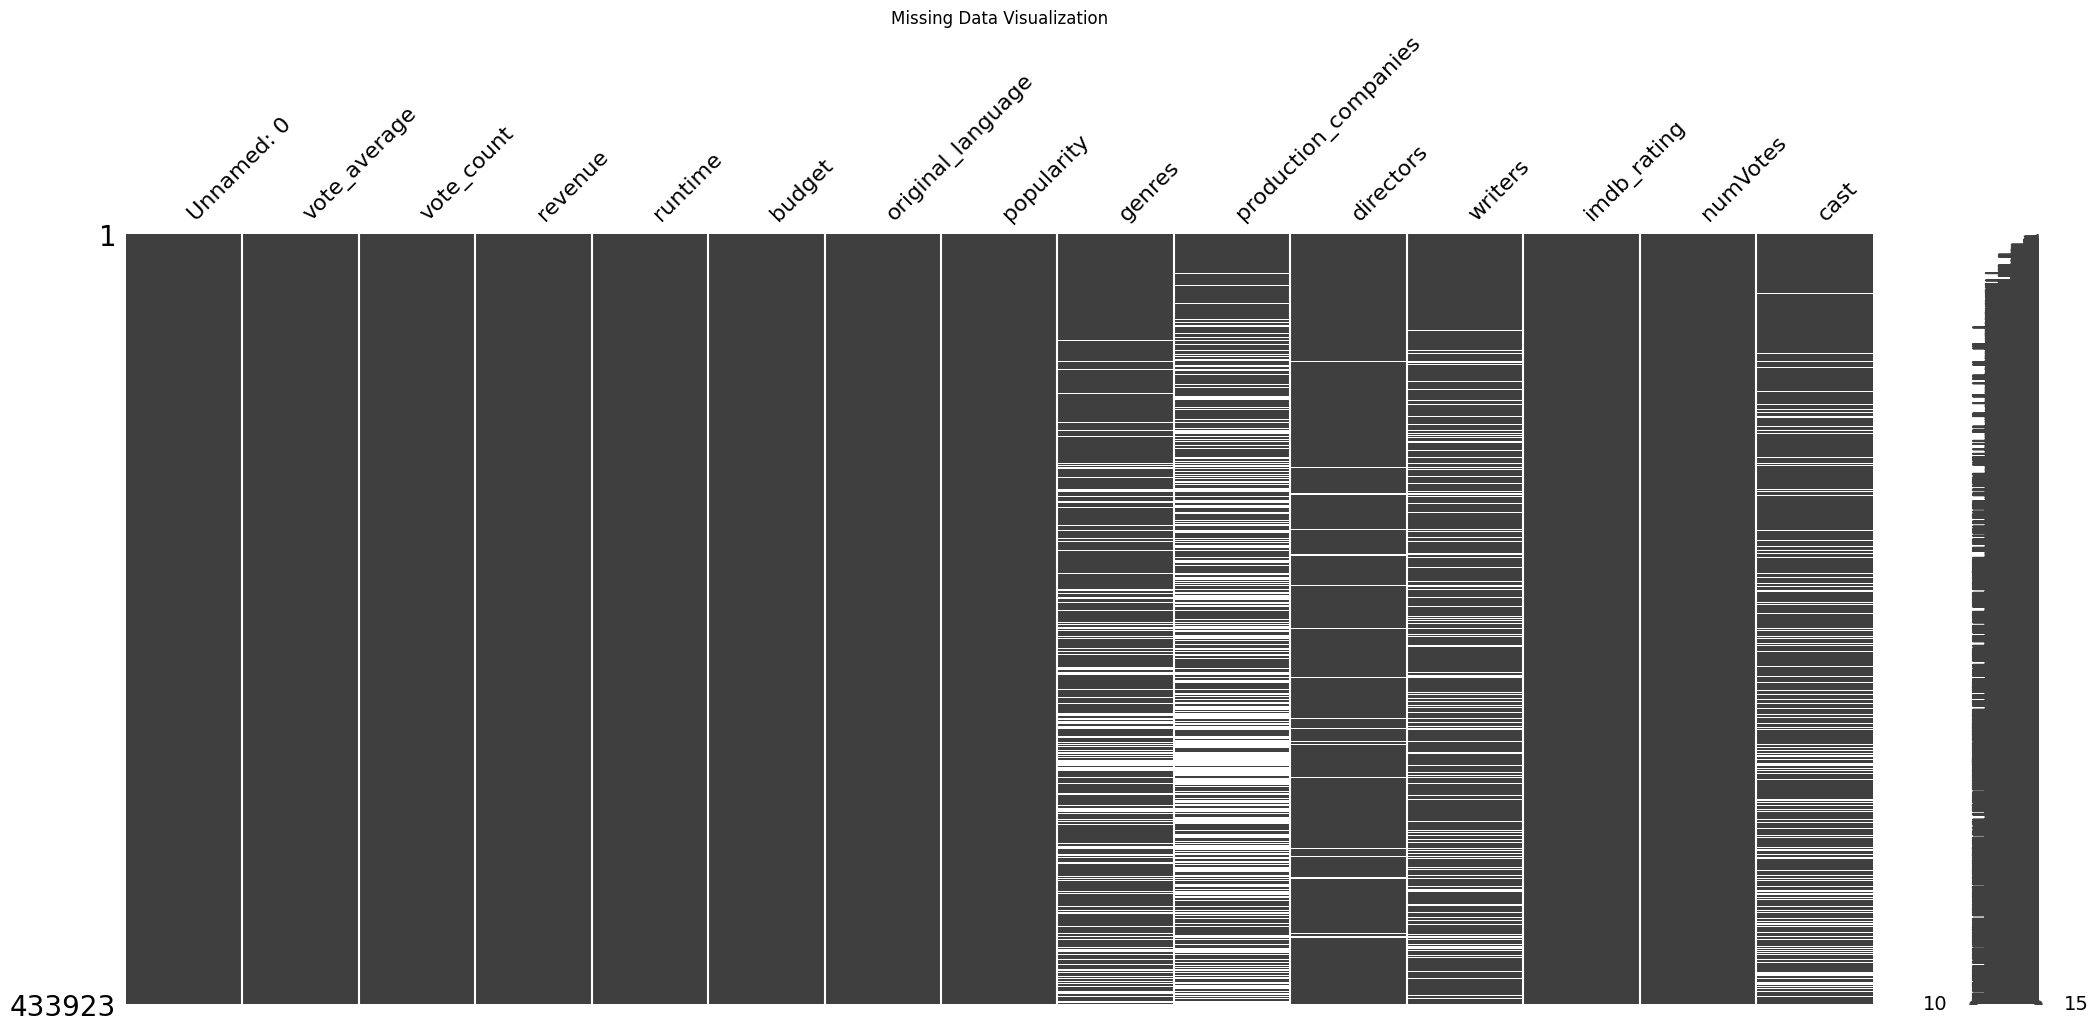

In [2]:

df = pd.read_csv(r"C:\Users\baldo\Downloads\TMDB_IMDB_Movies_Dataset.csv")

# Rename the IMDb column so it's clean
df = df.rename(columns={"Average Rating": "imdb_rating"})

# Visualize missing data
msno.matrix(df)
plt.title("Missing Data Visualization")
plt.show()

In [3]:
# Clean text columns
text_cols = ["genres", "cast", "directors", "writers", "production_companies"]

for col in text_cols:
    df[col] = df[col].fillna("").astype(str)

# B. Preprocessing
*This markdown includes the following:*
- handling missing values
- separating multiple values in one cell
- creating dataframe for the separated values
- OneHotEncoder, StandardScaler, LabelEncoder, MultiLabelBinarizer
- Computations to give independent variables more impact

In [4]:
# Convert numeric tas lagyan na lang ng median kung may kulang
df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
df["budget"].fillna(df["budget"].median(), inplace=True)
df["revenue"].fillna(df["revenue"].median(), inplace=True)

# Convert rating columns just to be safe
df["imdb_rating"] = pd.to_numeric(df["imdb_rating"], errors="coerce").fillna(0)
df["vote_average"] = pd.to_numeric(df["vote_average"], errors="coerce").fillna(0)
df["popularity"] = pd.to_numeric(df["popularity"], errors="coerce").fillna(0)


In [5]:
def split_list(x):
    return [i.strip() for i in x.split(",") if i.strip()] #pinaghihiwalay na mga laman ng cell basta makita na comma

df["genre_list"] = df["genres"].apply(split_list)
df["cast_list"] = df["cast"].apply(split_list)
df["writers_list"] = df["writers"].apply(split_list)
df["directors_list"] = df["directors"].apply(split_list)
df["company_list"] = df["production_companies"].apply(split_list)


In [6]:
#gawan na ng df ng mga cast1, cast2, cast3, writer1, writer2, director, company
safe = lambda L, i: L[i] if len(L) > i else "None"

df["cast1"] = df["cast_list"].apply(lambda x: safe(x, 0))
df["cast2"] = df["cast_list"].apply(lambda x: safe(x, 1))
df["cast3"] = df["cast_list"].apply(lambda x: safe(x, 2))

df["writer1"] = df["writers_list"].apply(lambda x: safe(x, 0))
df["writer2"] = df["writers_list"].apply(lambda x: safe(x, 1))

df["director"] = df["directors_list"].apply(lambda x: safe(x, 0))
df["company"] = df["company_list"].apply(lambda x: safe(x, 0))


In [7]:
# Build a set of unique names from all person-related columns to avoid creating a huge list
people_cols = ["cast1", "cast2", "cast3", "writer1", "writer2", "director", "company"]

unique_people = set()
for col in people_cols:
    # use .unique() to avoid expanding duplicates and .dropna() to skip NaNs
    unique_people.update(df[col].dropna().unique())

#Create the SINGLE global encoder
global_encoder = LabelEncoder()

#Fit using the unique names (much smaller memory footprint than the full concatenated list)
global_encoder.fit(list(unique_people))

# Transform each column with the SAME encoder
for col in people_cols:
    df[col + "_id"] = global_encoder.transform(df[col])


In [8]:

##gawan ng ID ng mga unique na cast, tas kahit nasa writer 1 or writer 2 na column siya, saime ID arin para alam ni model na iisang tao lang yon
cast_cols = ["cast1", "cast2", "cast3"]

# Collect all unique cast names
all_cast = set()
for col in cast_cols:
    all_cast.update(df[col].dropna().unique())

# Create cast encoder
cast_encoder = LabelEncoder()
cast_encoder.fit(list(all_cast))


for col in cast_cols:
    df[col + "_id"] = cast_encoder.transform(df[col])

print("Total unique CAST:", len(cast_encoder.classes_))


#gawan ng ID ng mga unique na writer, tas kahit nasa writer 1 or writer 2 na column siya, saime ID arin para alam ni model na iisang tao lang yon
writer_cols = ["writer1", "writer2"]

all_writers = set()
for col in writer_cols:
    all_writers.update(df[col].dropna().unique())

writer_encoder = LabelEncoder()
writer_encoder.fit(list(all_writers))

# Apply same writer encoder
for col in writer_cols:
    df[col + "_id"] = writer_encoder.transform(df[col])

print("Total unique WRITERS:", len(writer_encoder.classes_))


# gawan ng ID ng mga unique na director
director_encoder = LabelEncoder()
df["director_id"] = director_encoder.fit_transform(df["director"])

print("Total unique DIRECTORS:", len(director_encoder.classes_))


#Gawan ng ID ng mga unique na company
company_encoder = LabelEncoder()
df["company_id"] = company_encoder.fit_transform(df["company"])

print("Total unique COMPANIES:", len(company_encoder.classes_))

id_cols = [
    "cast1_id","cast2_id","cast3_id",
    "writer1_id","writer2_id",
    "director_id","company_id"
]


df["GoodBad"] = (df["imdb_rating"] >= 7.0).astype(int)


Total unique CAST: 342121
Total unique WRITERS: 217558
Total unique DIRECTORS: 140483
Total unique COMPANIES: 76385


In [9]:
def compute_reputation_score(df, col_id):
    """
    Computes the average IMDb rating of all movies a contributor worked on.
    This represents their reputation score (continuous score).
    """
    # Group by contributor ID, compute mean IMDb rating
    rep_map = (
        df.groupby(col_id)["imdb_rating"]
        .mean()
        .to_dict()
    )
    
    # Map reputation score back to dataframe
    return df[col_id].map(lambda x: rep_map.get(x, 0))


score_cols = []

# --- CAST SCORES ---
for c in cast_cols:
    col_id = c + "_id"
    score_col = c + "_score"
    df[score_col] = compute_reputation_score(df, col_id)
    score_cols.append(score_col)

# --- WRITER SCORES ---
for w in writer_cols:
    col_id = w + "_id"
    score_col = w + "_score"
    df[score_col] = compute_reputation_score(df, col_id)
    score_cols.append(score_col)

# --- DIRECTOR SCORE ---
df["director_score"] = compute_reputation_score(df, "director_id")
score_cols.append("director_score")

# --- COMPANY SCORE ---
df["company_score"] = compute_reputation_score(df, "company_id")
score_cols.append("company_score")

df["pop_norm"] = (df["popularity"] / df["popularity"].max()) * 10 

# Profit feature
df["profit"] = df["revenue"] - df["budget"]
df["profit_norm"] = (df["profit"] - df["profit"].min()) / (df["profit"].max() - df["profit"].min()) * 10

#score mean ng mga independent
df["score_mean"] = df[
    ["cast1_score","cast2_score","cast3_score",
     "writer1_score","writer2_score",
     "director_score","company_score"]
].mean(axis=1)

# Normalize score_mean
df["score_norm"] = (df["score_mean"] / df["score_mean"].max()) * 10

# FINAL WEIGHTED SCORE
df["quality_score"] = (
    0.70 * df["imdb_rating"] +
    0.10 * df["vote_average"] +
    0.05 * df["pop_norm"] +
    0.10 * df["score_norm"] +
    0.05 * df["profit_norm"]
)


In [10]:
# Restrict MultiLabelBinarizer to a fixed set of known genres (prevents exploding classes)
known_genres = [
	"Action","Adventure","Animation","Comedy","Crime","Documentary","Drama",
	"Family","Fantasy","History","Horror","Music","Mystery","Romance",
	"Science Fiction","TV Movie","Thriller","War","Western"
]


mlb = MultiLabelBinarizer(classes=known_genres)
genre_matrix = mlb.fit_transform(df["genre_list"]).astype("uint8")

genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_, index=df.index)

all_genres = list(mlb.classes_)

df = pd.concat([df, genre_df], axis=1)



In [11]:

#gawa ng score column para dito na lang tumingin yung model sa pagbebase kung magsling yung company o director, o cast o writer

genre_cols = list(mlb.classes_)  #yung mlb yung one hot, nilagyan na lang ng ibang name para madaling maintindihan

# ID COLUMNS
id_cols = [
    "cast1_id","cast2_id","cast3_id",
    "writer1_id","writer2_id",
    "director_id","company_id"
]

# SCORE COLUMNS
score_cols = [
    "cast1_score","cast2_score","cast3_score",
    "writer1_score","writer2_score",
    "director_score","company_score"
]

# NUMERIC COLS = BUDGET + REVENUE + SCORE COLS
numeric_cols = ["budget", "revenue"] + score_cols



# DEFINE NUMERIC COLUMNS (Budget + Revenue + Scores)

numeric_cols = ["budget", "revenue",] + score_cols

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


df.head()

FEATURE_ORDER = genre_cols + id_cols + numeric_cols + score_cols


#FEATURES (X) = GENRE ONE‑HOT + SCORES + NUMERIC

X = df[genre_cols + id_cols + numeric_cols + score_cols]  # numeric_cols already contains score_cols
y = df["GoodBad"]

FEATURE_ORDER = list(X.columns)



# C. Testing Model
*This markdown includes the following:*
- Training the model
- Identifying Accuracy, Classification report and Confusion matrix
- Testing the Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

c:\Users\baldo\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [13]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8830788730771447
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     60603
           1       0.83      0.77      0.80     26182

    accuracy                           0.88     86785
   macro avg       0.87      0.85      0.86     86785
weighted avg       0.88      0.88      0.88     86785

Confusion matrix:
[[56380  4223]
 [ 5924 20258]]


In [14]:
training_features = genre_cols + id_cols + numeric_cols + score_cols
print("Training feature count:", len(training_features))

# IMPORTANT: save feature list
FEATURE_ORDER = training_features


Training feature count: 42


In [15]:
def predict_movie(
    cast1_id, cast2_id, cast3_id,
    writer1_id, writer2_id,
    director_id, company_id,
    budget, revenue,
    genre_dict,
    scaler, model,
    genre_cols, id_cols, numeric_cols, score_cols
):

    # Create empty df
    df_row = pd.DataFrame([{col:0 for col in FEATURE_ORDER}])

    # GENRES
    for g in genre_cols:
        df_row.loc[0, g] = genre_dict.get(g, 0)

    # IDs
    df_row.loc[0, "cast1_id"] = cast1_id
    df_row.loc[0, "cast2_id"] = cast2_id
    df_row.loc[0, "cast3_id"] = cast3_id
    df_row.loc[0, "writer1_id"] = writer1_id
    df_row.loc[0, "writer2_id"] = writer2_id
    df_row.loc[0, "director_id"] = director_id
    df_row.loc[0, "company_id"] = company_id

    # Base numeric
    df_row.loc[0, "budget"] = budget
    df_row.loc[0, "revenue"] = revenue

    # SCORE COLUMNS MUST BE ZERO (model trained on them scaled)
    for sc in score_cols:
        df_row.loc[0, sc] = 0

    # SCALE numeric columns
    df_row[numeric_cols] = scaler.transform(df_row[numeric_cols])

    # FIX COLUMN ORDER
    final_df = df_row[FEATURE_ORDER]

    # Predict
    pred = model.predict(final_df)[0]
    prob = model.predict_proba(final_df)[0][1]

    return pred, prob


In [16]:
# ----------------------------------------
# TESTING INPUT VALUES
# ----------------------------------------

genre_input = {
    "Action": 1,
    "Adventure": 1,
    "Animation": 0,
    "Comedy": 1,
    "Crime": 0,
    "Documentary": 0,
    "Drama": 0,
    "Family": 0,
    "Fantasy": 0,
    "History": 0,
    "Horror": 0,
    "Music": 0,
    "Mystery": 0,
    "Romance": 0,
    "Science Fiction": 0,
    "TV Movie": 0,
    "Thriller": 1,
    "War": 0,
    "Western": 0
}

pred, prob = predict_movie(
    cast1_id=144000,
    cast2_id=265268,
    cast3_id=227673,
    writer1_id=192236,
    writer2_id=153244,
    director_id=123982,
    company_id=11219,
    budget=35000000,
    revenue=99423521,
    genre_dict=genre_input,
    scaler=scaler,
    model=model,
    genre_cols=genre_cols,
    id_cols=id_cols,
    numeric_cols=numeric_cols,
    score_cols=score_cols
)

print("Prediction:", pred)
print("Probability GOOD:", prob)


Prediction: 0
Probability GOOD: 4.618723942256128e-20


# Visualizations
*Here lies the three visualizations used to interpret the data and resources.*

C:\Users\baldo\AppData\Local\Temp\ipykernel_808\3431213463.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([bad, good], labels=["Bad (0)", "Good (1)"], showfliers=False)
C:\Users\baldo\AppData\Local\Temp\ipykernel_808\3431213463.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([bad, good], labels=["Bad (0)", "Good (1)"], showfliers=False)
C:\Users\baldo\AppData\Local\Temp\ipykernel_808\3431213463.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([bad, good], labels=["Bad (0)", "Good (1)"], showfliers=False)
C:\Users\baldo\AppData\Local\Temp\ipykernel_808\3431

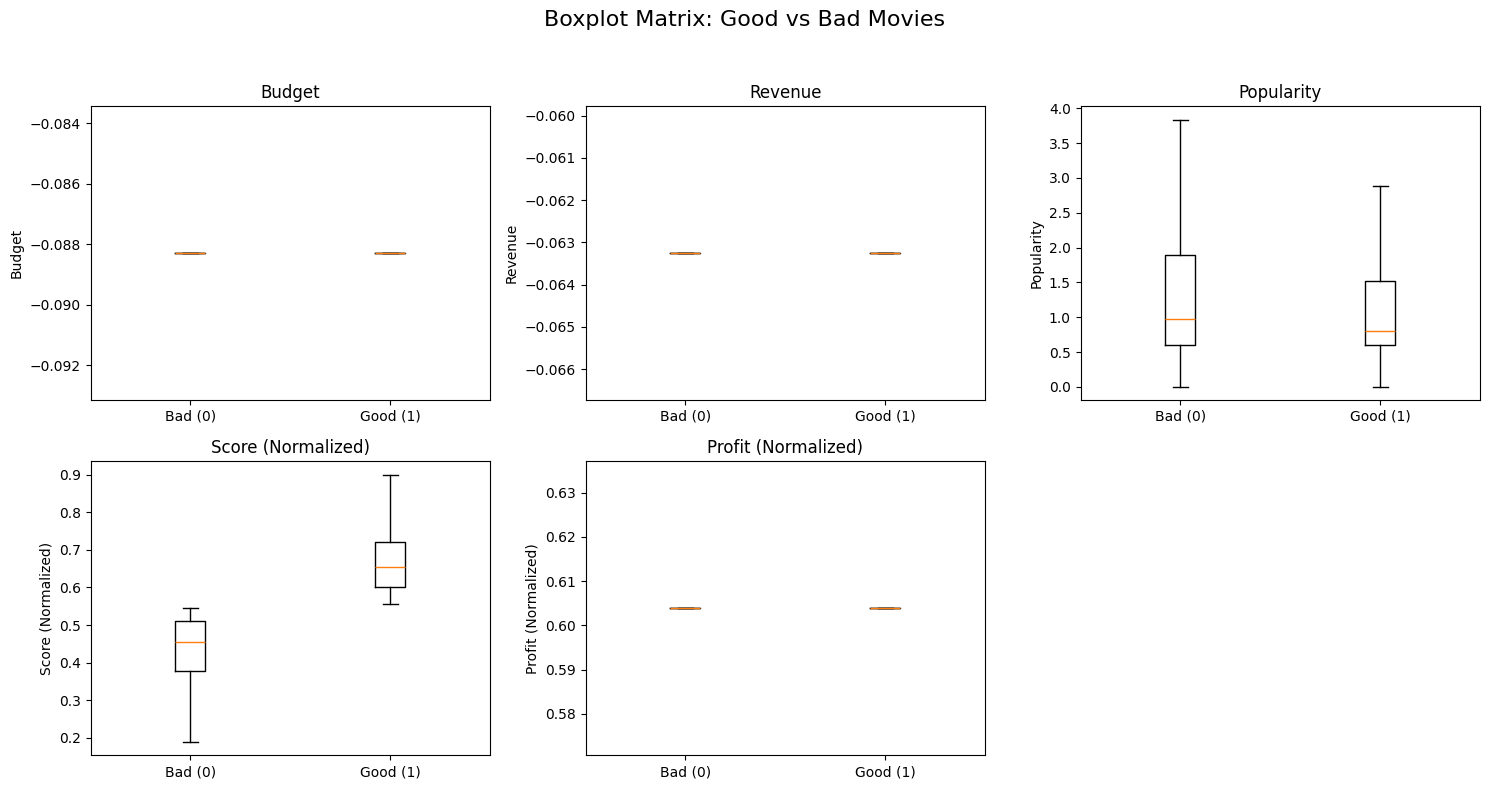

In [17]:
# Convert needed columns to numeric
for col in ["imdb_rating", "budget", "revenue", "popularity"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Create Good vs Bad label (Good = 1 if rating >= 6.0)
df["GoodBad"] = (df["imdb_rating"] >= 6.0).astype(int)

# Profit + normalization
df["profit"] = df["revenue"] - df["budget"]

def minmax_norm(s):
    s = s.replace([np.inf, -np.inf], np.nan)
    smin, smax = s.min(skipna=True), s.max(skipna=True)
    if pd.isna(smin) or pd.isna(smax) or smax == smin:
        return np.nan
    return (s - smin) / (smax - smin)

df["score_norm"] = minmax_norm(df["imdb_rating"])
df["profit_norm"] = minmax_norm(df["profit"])

# Features for the boxplot matrix (raw values)
features = [
    ("budget", "Budget"),
    ("revenue", "Revenue"),
    ("popularity", "Popularity"),
    ("score_norm", "Score (Normalized)"),
    ("profit_norm", "Profit (Normalized)")
]

# Create 2x3 boxplot matrix
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (feature, label) in enumerate(features):
    sub = df[["GoodBad", feature]].dropna()
    bad = sub[sub["GoodBad"] == 0][feature]
    good = sub[sub["GoodBad"] == 1][feature]

    axes[i].boxplot([bad, good], labels=["Bad (0)", "Good (1)"], showfliers=False)
    axes[i].set_title(label)
    axes[i].set_ylabel(label)

# Hide the last empty subplot
axes[-1].axis("off")

plt.suptitle("Boxplot Matrix: Good vs Bad Movies", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])


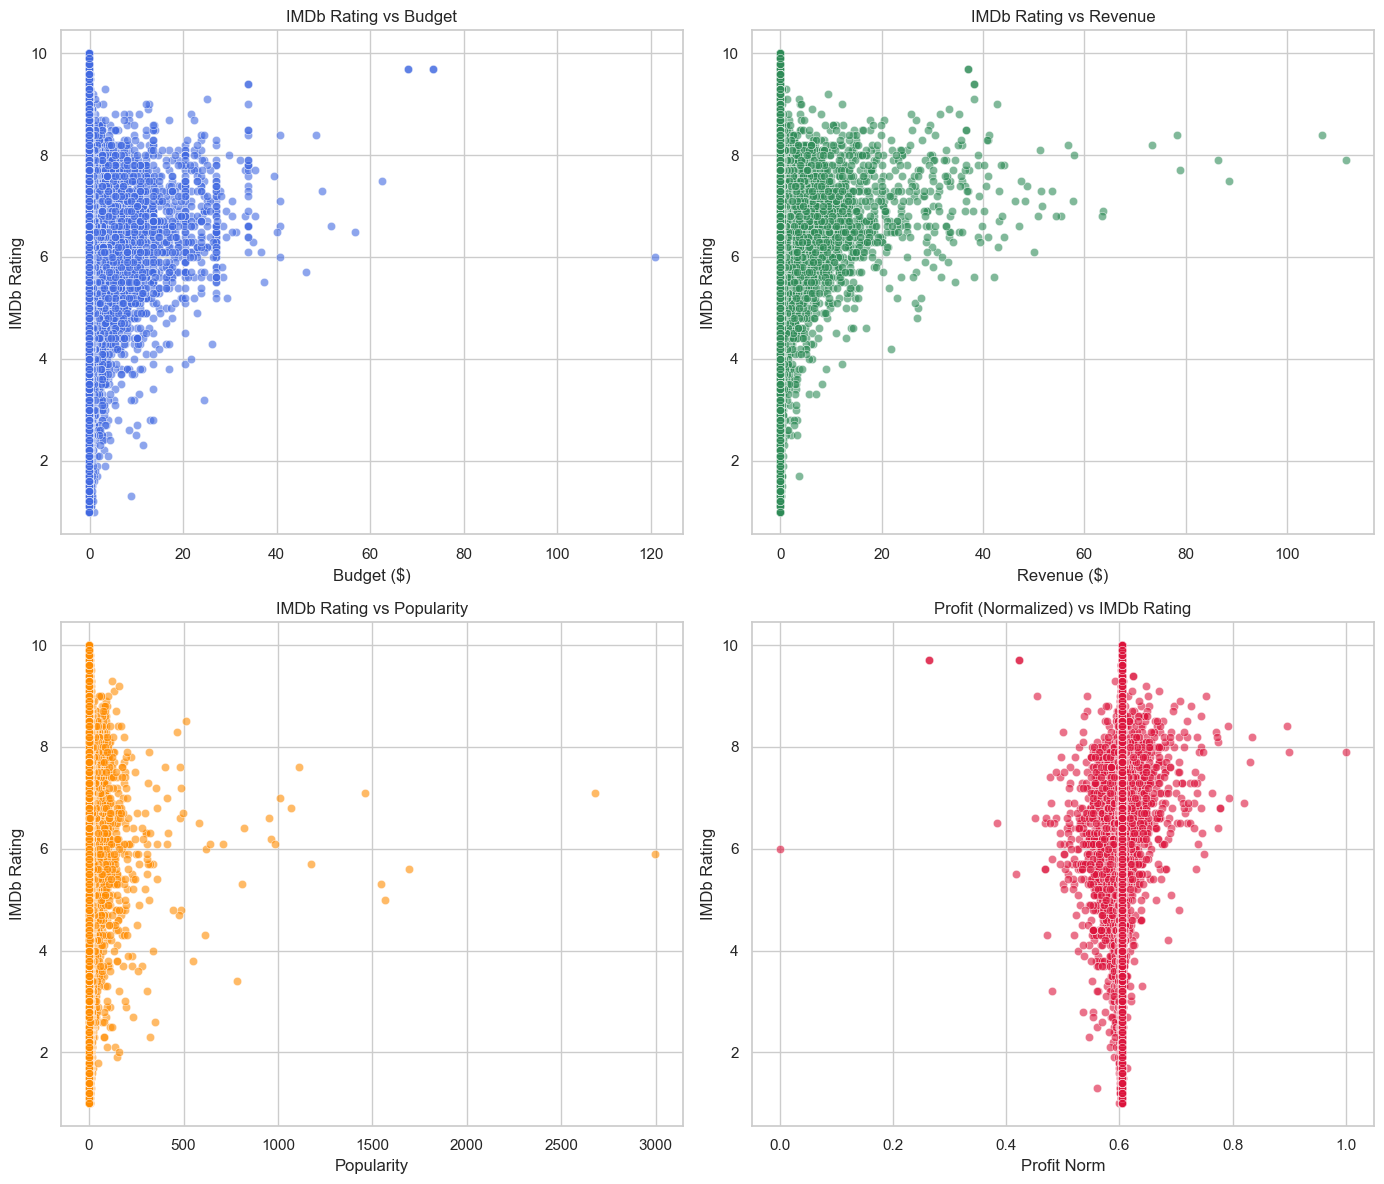

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set(style="whitegrid")

# Create the 2x2 subplots figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# -------------------------
# PLOT A — IMDb Rating vs Budget
# -------------------------
sns.scatterplot(data=df, x="budget", y="imdb_rating", alpha=0.6, ax=axes[0, 0], color="royalblue")
axes[0, 0].set_title("IMDb Rating vs Budget")
axes[0, 0].set_xlabel("Budget ($)")
axes[0, 0].set_ylabel("IMDb Rating")

# -------------------------
# PLOT B — IMDb Rating vs Revenue
# -------------------------
sns.scatterplot(data=df, x="revenue", y="imdb_rating", alpha=0.6, ax=axes[0, 1], color="seagreen")
axes[0, 1].set_title("IMDb Rating vs Revenue")
axes[0, 1].set_xlabel("Revenue ($)")
axes[0, 1].set_ylabel("IMDb Rating")

# -------------------------
# PLOT C — IMDb Rating vs Popularity
# -------------------------
sns.scatterplot(data=df, x="popularity", y="imdb_rating", alpha=0.6, ax=axes[1, 0], color="darkorange")
axes[1, 0].set_title("IMDb Rating vs Popularity")
axes[1, 0].set_xlabel("Popularity")
axes[1, 0].set_ylabel("IMDb Rating")

# -------------------------
# PLOT D — Profit Norm vs IMDb rating
# -------------------------
sns.scatterplot(data=df, x="profit_norm", y="imdb_rating", alpha=0.6, ax=axes[1, 1], color="crimson")
axes[1, 1].set_title("Profit (Normalized) vs IMDb Rating")
axes[1, 1].set_xlabel("Profit Norm")
axes[1, 1].set_ylabel("IMDb Rating")

# Layout fix
plt.tight_layout()
plt.show()


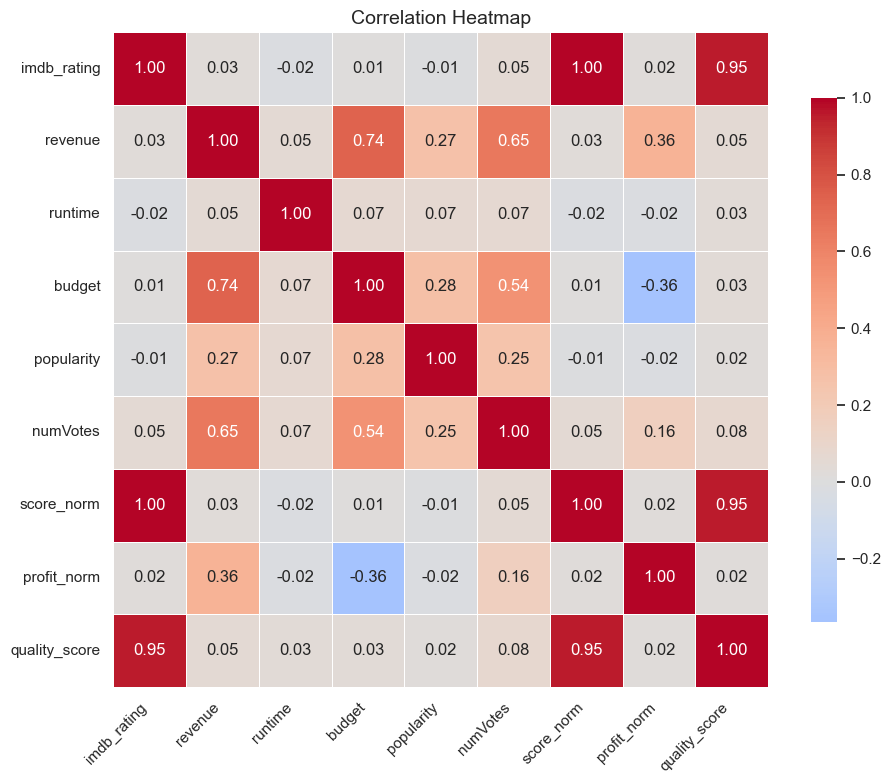

In [19]:
# Convert relevant columns to numeric
numeric_cols = [
    "imdb_rating",
    "revenue",
    "runtime",
    "budget",
    "popularity",
    "numVotes", 
    "score_norm",
    "profit_norm",
    "quality_score"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Select numeric features
numeric_df = df[numeric_cols]

# Compute correlation matrix
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,           # show values
    fmt=".2f",             # 2 decimal places
    cmap="coolwarm",       # red-blue color scheme
    center=0,              # center at zero
    square=True,           # square cells
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()


# Insights
*Here lies the insights containing the model performance, features and result interpretation and lastly, suggestions to improve the model*

1. *The model achieved a performance accuracy of approximately 88%, with the confusion matrix indicating that it is more effective at identifying BAD movies than GOOD ones. The prediction probabilities show clear confidence separation, meaning the model reliably distinguishes strong GOOD indicators from weak ones.  Additionally, this kind of percentage or accuracy is highly expected due to IMDb ratings complexity and more audience influenced as past data checking showed how movie trends and popularity are randomized and throughout the years have no predictable pattern- though genre, cast, directors, writers, budget, company and revenue have influence, the bigger impact lays on audience impact.* 
- *Prediction shows the classification if the inputs give a Good (1) or Bad (0) IMDb and Probability GOOD, shows the the percentage of how confident the model is with its prediction since Good ranges from 6-10 and Bad from 0-5, prediction GOOD displays its confidence on how Good or Bad the movie would be.*

2. Feature bahviors shown using visualizations:
- *The boxplot matrix shows that the distributions of budget, revenue, and profit are heavily overlapping between good and bad movies, indicating that financial metrics alone are not reliable predictors of movie quality. Popularity reveals only a small distinction between the two classes, suggesting limited influence on ratings. In contrast, the normalized rating score demonstrates the clearest separation, reinforcing that audience or critic evaluation remains the strongest single indicator for classification. This pattern is supported by the scatter plots.*
- *The scatter plots shows where IMDb ratings show very weak relationships with budget, revenue, and popularity, meaning that big budgets or high earnings do not necessarily translate to higher-rated films. The scatter plots also highlight a predictable strong correlation between budget and revenue, reflecting standard industry behavior—larger productions often earn more.*
- *Meanwhile, the correlation heatmap confirms strong interrelationships among financial and engagement-related variables such as budget, revenue, and vote counts, but shows that IMDb rating has little correlation with any of them. Overall, these visualizations suggest that movie quality is influenced more by creative, narrative, and talent-related factors rather than by financial investment or commercial performance, validating why rating-based features provide the clearest signal for your model.*

3. *Suggestions in improving the model consists of trying a different model such as RandomForest, due to its ability being able to differentiate values more accurately compared to Logistics.  When tried, the accuracy increased to 99%. But when retaining the model, incorporating richer, content‑based features—such as sentiment scores from plot summaries, TF‑IDF vectors from movie descriptions could help the model capture deeper relationships that are not reflected in numerical metadata alone.*

# CSV ID Export

In [20]:

# Columns to export kasi ang daming ID na nagawa, gusto ko malaman yon para meron matignan kapag testing
id_cols_export = [
    "cast1", "cast1_id",
    "cast2", "cast2_id",
    "cast3", "cast3_id",
    "writer1", "writer1_id",
    "writer2", "writer2_id",
    "director", "director_id",
    "company", "company_id",
    "budget", "revenue"
]

# Path to Downloads folder (Windows compatible)
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "ID_Table_All.csv")

# Export CSV 
df[id_cols_export].to_csv(downloads_path, index=False)

print(f"Exported → {downloads_path}")


Exported → C:\Users\baldo\Downloads\ID_Table_All.csv
